<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Script-setup" data-toc-modified-id="Script-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Script setup</a></span></li><li><span><a href="#Data-directory-preparention" data-toc-modified-id="Data-directory-preparention-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data directory preparention</a></span></li><li><span><a href="#Data-file-preperation" data-toc-modified-id="Data-file-preperation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data file preperation</a></span><ul class="toc-item"><li><span><a href="#input-directory-(all-general-raw-data-files)" data-toc-modified-id="input-directory-(all-general-raw-data-files)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>input</code> directory (all general raw data files)</a></span></li><li><span><a href="#processed-directory-(all-data-files-produced-in-this-repository)" data-toc-modified-id="processed-directory-(all-data-files-produced-in-this-repository)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>processed</code> directory (all data files produced in this repository)</a></span></li></ul></li><li><span><a href="#Load-data-functions" data-toc-modified-id="Load-data-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data functions</a></span></li><li><span><a href="#Load-data-sets" data-toc-modified-id="Load-data-sets-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load data sets</a></span></li><li><span><a href="#Power-plant-CO2-Signals" data-toc-modified-id="Power-plant-CO2-Signals-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Power plant CO2 Signals</a></span><ul class="toc-item"><li><span><a href="#Plant-Level" data-toc-modified-id="Plant-Level-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plant Level</a></span></li><li><span><a href="#Technology-Level" data-toc-modified-id="Technology-Level-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Technology Level</a></span></li><li><span><a href="#Country-level" data-toc-modified-id="Country-level-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Country level</a></span></li><li><span><a href="#Signal-analysis" data-toc-modified-id="Signal-analysis-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Signal analysis</a></span></li><li><span><a href="#CO2-Signal-Example" data-toc-modified-id="CO2-Signal-Example-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>CO2 Signal Example</a></span></li></ul></li><li><span><a href="#ENTSO-E-generation-per-technology-CO2-Signal" data-toc-modified-id="ENTSO-E-generation-per-technology-CO2-Signal-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>ENTSO-E generation per technology CO2 Signal</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#CO2-Signal-Example" data-toc-modified-id="CO2-Signal-Example-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>CO2 Signal Example</a></span></li><li><span><a href="#CO2-Duration-Curves" data-toc-modified-id="CO2-Duration-Curves-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>CO2 Duration Curves</a></span></li><li><span><a href="#Carbon-Intensity-Heat-Map" data-toc-modified-id="Carbon-Intensity-Heat-Map-8.1.3"><span class="toc-item-num">8.1.3&nbsp;&nbsp;</span>Carbon Intensity Heat Map</a></span></li></ul></li></ul></li><li><span><a href="#Export-final-CO2-signals" data-toc-modified-id="Export-final-CO2-signals-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Export final CO2 signals</a></span></li></ul></div>

# Introduction

This notebook uses the calculated EFs to design an hourly CO2 emission signal for EU countries.

# Script setup

In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 
import datetime


%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_theme()

#helpers
from helpers import change_ENTSOE_ProductionTypeName
from helpers import load_timeseries_ENTSOE

# Data directory preparention

Create input, processed and output folders if they don't exist
If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final emission factors

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

## `input` directory (all general raw data files)

- 1) ENTSO-E production per type
Production per type from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Production Type Available online: 
https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show
Processed with the following script that converts the data to hourly resolution (private script from INATECH):


 File - > time_series_60min_multiindex.csv - > generation per technology
 
- 2) ENTSO-E production per unit
Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution (private script from INATECH):
https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit

File - > gen_data.csv -> hourly generation data per unit

In [3]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(input_directory_path) :
    print("The directory for the bootom up method is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(input_directory_path, fn) for fn in os.listdir(input_directory_path)]

print(filenames)

['input\\Bootom_up_methode', 'input\\CO2_Signal', 'input\\EEA_Method', 'input\\gen_data.csv', 'input\\Matching', 'input\\time_series_60min_multiindex.csv', 'input\\unit_data.csv']


## `processed` directory (all data files produced in this repository)

- 1) EF per type and county

File - > EF_bottom_up_methode.csv

- 2) EF per unit

File -> generation_unit_EF_bottom_up_methode.csv

In [4]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(processed_directory_path) :
    print("The directory for the CO2 Signal is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(processed_directory_path, fn) for fn in os.listdir(processed_directory_path)]

print(filenames)

['processed\\CI_bottom_up_methode.csv', 'processed\\EF_bottom_up_methode.csv', 'processed\\generation_unit_EF_bottom_up_methode.csv', 'processed\\Matching_Entso_EUTL_EU.csv', 'processed\\_CO2_intensity_by_technology.png']


# Load data functions

In [5]:
def load_generation_per_unit(path, fn):
    """
    Load the ENTSO-E gernation per unit data.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    
    return generation

def load_unit_CO2_data(path, fn):
    """
    Own generation unit information with CO2 information per unit
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)
    
    # set name for the index
    df.index.set_names('GenerationUnitEIC', inplace=True)

    return df

def load_EF(path, fn):
    """
    Own generation EF per tech and country
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=[0,1])
    
    return df

# Load data sets

#### Load power plant generation data

In [6]:
generation_per_unit = load_generation_per_unit(input_directory_path, 'gen_data.csv')

#### Load power plant emission info data

In [7]:
generation_unit_info = load_unit_CO2_data(processed_directory_path, 'generation_unit_EF_bottom_up_methode.csv')

#### Load ENTSO-E generation per type

In [8]:
entsoe_gen_type = load_timeseries_ENTSOE(input_directory_path, 'time_series_60min_multiindex.csv')

#### Load EF per technology

In [9]:
EF = load_EF(processed_directory_path, 'EF_bottom_up_methode.csv')

#### Filter generation set to generation info data

In [10]:
generation_per_unit = generation_per_unit[generation_unit_info.index]

# Power plant CO2 Signals

In this section we build CO2 signal out of the used per power plant generation data. We limit the used generation to the generation units where we where able to calculated EFs.

In [11]:
generation_per_unit = generation_per_unit[generation_unit_info.index]

In [12]:
generation_per_unit.head(5)

,14WENERGIEAGWT4S,45W000000000032T,45W000000000033R,45W000000000034P,45W000000000040U,45W000000000035N,45W000000000099Y,45W000000000038H,14W-GEN-DO3----F,14W-WML-M1-----G,...,26WUULA-CASELL2N,26WUULA-CASELL4J,26WUULA-CASELL1P,26WUULA-CASELL3L,48W00000EGGPS-1X,48W00000EGGPS-4R,48W00000EGGPS-3T,48W00000EGGPS-2V,48W000000SUTB-1P,48W000000DEEP-1N
2018-01-01 00:00:00,0.0,20.53,0.0,0.42,0.0,48.83,0.0,118.23,0.0,150.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,19.81,0.0,0.39,0.0,48.96,0.0,103.25,0.0,149.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00,0.0,19.63,0.0,0.42,0.0,49.03,0.0,102.62,0.0,149.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 03:00:00,0.0,22.39,0.0,0.40,0.0,48.93,0.0,103.04,0.0,148.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 04:00:00,0.0,23.08,0.0,0.42,0.0,49.05,0.0,80.15,0.0,149.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
generation_unit_info.head(5)

,MapCode,EUTL_countrycode,ProductionTypeName,index,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,PowerSystemResourceName,duplicate_count,...,VERIFIED_EMISSIONS_2009,ALLOCATION_2008,VERIFIED_EMISSIONS_2008,ACCOUNT_CLOSURE,side_generation,PP_emissions,PP_EF,CI_validation,Tech_EF,Country_EF
GenerationUnitEIC,,,,,,,,,,,,,,,,,,,,,
14WENERGIEAGWT4S,AT,AT,gas,1,10YAT-APG------L,APG CA,CTA,400.0,Kraftwerk Timelkam GUD,2.0,...,340026,218704,103553,OPEN,685235.67,2.672040e+05,0.389945,True,0.360910,0.427776
45W000000000032T,DK,DK,hard_coal,6,10Y1001A1001A796,Energinet CA,CTA,147.0,Asnaesvaerket 2,1.0,...,2430356,1765318,2484733,OPEN,770018.30,2.501768e+05,1.140746,True,0.959711,0.934412
45W000000000033R,DK,DK,hard_coal,7,10Y1001A1001A796,Energinet CA,CTA,640.0,Asnaesvaerket 5,1.0,...,2430356,1765318,2484733,OPEN,770018.30,6.282182e+05,1.140746,True,0.959711,0.934412
45W000000000034P,DK,DK,hard_coal,8,10Y1001A1001A796,Energinet CA,CTA,250.0,Amagervaerket 3,1.0,...,1684995,1250995,1089604,OPEN,1060165.23,1.038454e+06,0.979521,True,0.959711,0.934412
45W000000000040U,DK,DK,hard_coal,9,10Y1001A1001A796,Energinet CA,CTA,377.0,Esbjergvaerket 3,1.0,...,1318927,1051489,1158930,OPEN,1193633.83,1.066679e+06,0.893640,True,0.959711,0.934412


## Plant Level

In [14]:
CO2_emission_per_unit_EF = generation_per_unit.multiply((generation_unit_info.PP_EF), axis='columns')

In [15]:
CO2_emission_per_unit_EF.dropna(axis=1, inplace=True)

In [16]:
CO2_emission_per_unit_EF.sum(axis=1).describe()

count      8760.000000
mean      62454.893328
std       14436.974738
min           0.000000
25%       51993.841567
50%       62073.329628
75%       72049.809056
max      103855.609255
dtype: float64

## Technology Level

In [17]:
CO2_emission_per_tech_EF = generation_per_unit.multiply((generation_unit_info.Tech_EF), axis='columns')

In [18]:
CO2_emission_per_tech_EF.dropna(axis=1, inplace=True)

In [19]:
CO2_emission_per_tech_EF.sum(axis=1).describe()

count      8760.000000
mean      62454.893328
std       14522.561053
min           0.000000
25%       51983.451989
50%       62122.937205
75%       72060.397950
max      103874.373497
dtype: float64

## Country level

In [20]:
CO2_emission_per_country_EF = generation_per_unit.multiply((generation_unit_info.Country_EF), axis='columns')

In [21]:
CO2_emission_per_country_EF.dropna(axis=1, inplace=True)

In [22]:
CO2_emission_per_country_EF.sum(axis=1).describe()

count      8760.000000
mean      62454.893328
std       15657.842613
min           0.000000
25%       50687.041429
50%       61782.617702
75%       73049.248305
max      105483.463129
dtype: float64

## Signal analysis 

#### Scatter Plot

In [23]:
Carbon_intensitiy = pd.DataFrame()
Carbon_intensitiy['unit_EF'] = ((CO2_emission_per_unit_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['tech_EF'] = ((CO2_emission_per_tech_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['country_EF'] = ((CO2_emission_per_country_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))

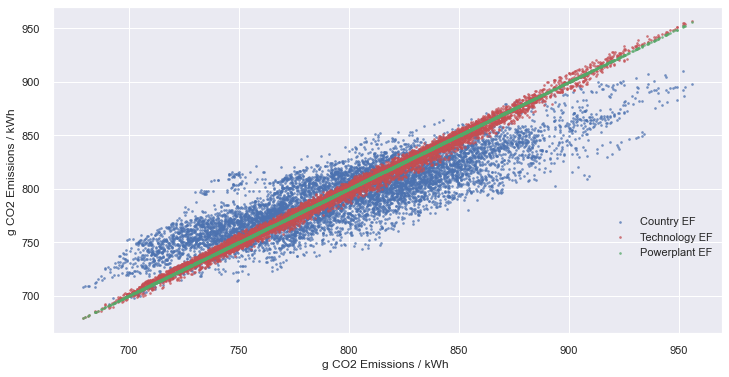

In [24]:
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)


Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="country_EF", ax=ax, alpha=0.6, color='b', s=3)

Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="tech_EF", ax=ax, alpha=0.6, color='r', s=3)

Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="unit_EF", ax=ax, alpha=0.6, color='g', s=3)



ax.set_ylabel("g CO2 Emissions / kWh ")
ax.set_xlabel("g CO2 Emissions / kWh ")

ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(1.0, 0.2))

In [25]:
Carbon_intensitiy_per_country_unit_EF = ((CO2_emission_per_unit_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum()) / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()
Carbon_intensitiy_per_country_tech_EF = (CO2_emission_per_tech_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum() / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()
Carbon_intensitiy_per_country_country_EF = (CO2_emission_per_country_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum() / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()

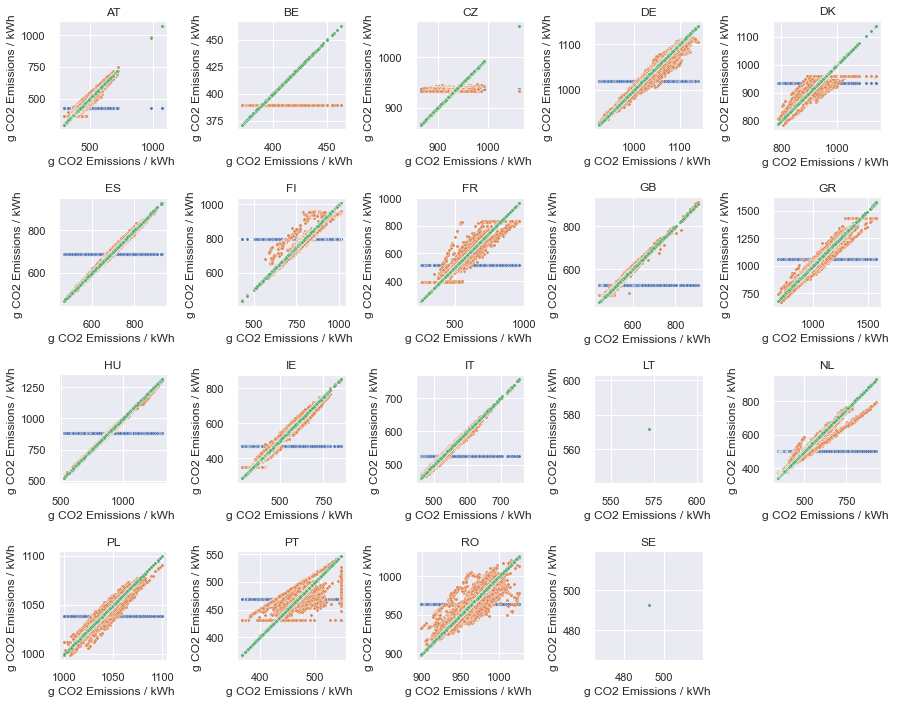

In [26]:
n_graphs = len(Carbon_intensitiy_per_country_unit_EF.columns)
n_cols = 5
    
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

fig.delaxes(axes[3][4])

size = 2.5

fig.set_size_inches(size*n_cols,size*n_rows)
    
    
for i, country in enumerate(Carbon_intensitiy_per_country_unit_EF.columns):
    i_row = i // n_cols
    i_col = i % n_cols
        
    ax = axes[i_row,i_col]
    
    ax.set(aspect='equal')
    
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_country_EF.loc[:,country], s=10, ax=ax)
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_tech_EF.loc[:,country], s=10, ax=ax)
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_unit_EF.loc[:,country], s=10, ax=ax)
    
        #max_lim = (max(entso_DE.loc[:,tech].max(),generation_DE.loc[:,tech].max())//1000)*1000+1000
        #if max_lim < 0:
        #    max_lim = 0
        
        #min_lim = (min(entso_DE.loc[:,tech].min(),generation_DE.loc[:,tech].min())//1000)*1000-1000
        #if min_lim < 0:
        #    min_lim = 0
    
    ax.set_title(country)
        #ax.set_xlim(min_lim,max_lim)
        #ax.set_ylim(min_lim,max_lim)
        
    ax.set_xlabel("g CO2 Emissions / kWh ")
    ax.set_ylabel("g CO2 Emissions / kWh ")
    
    fig.tight_layout()
    
ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(2.8, 0.5))

#### EF distribution

Text(0.5, 0, 'Country')

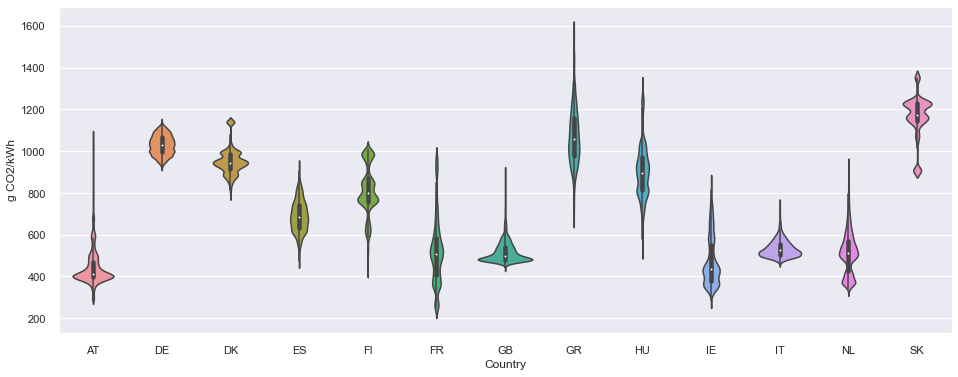

In [27]:
# per unit EF
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(16,6)
ax = sns.violinplot(data=Carbon_intensitiy_per_country_unit_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

Text(0.5, 0, 'Country')

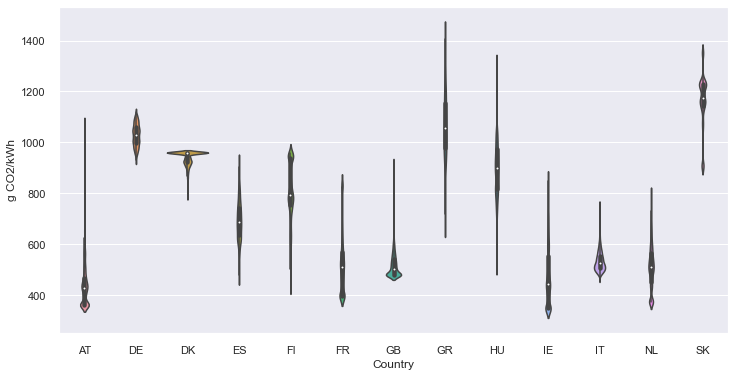

In [28]:
# per tech ef
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)

ax = sns.violinplot(data=Carbon_intensitiy_per_country_tech_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

Text(0.5, 0, 'Country')

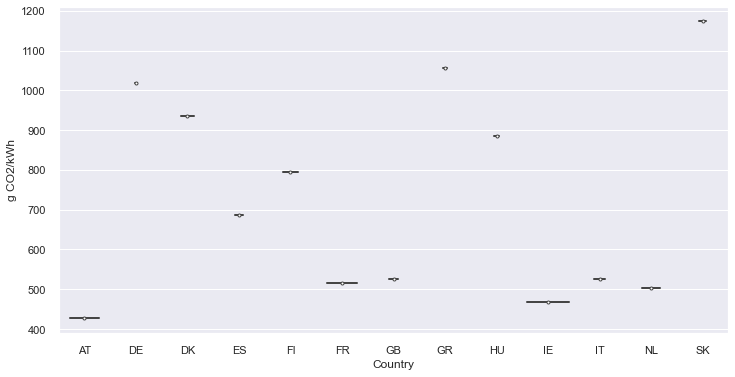

In [29]:
# per country EF
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)

ax = sns.violinplot(data=Carbon_intensitiy_per_country_country_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

## CO2 Signal Example

The following plot shows an example of the three generated CO2 Signals

In [30]:
def plot_production_profile(generation, CO2_emission_per_unit_EF, CO2_emission_per_tech_EF, CO2_emission_per_country_EF, generators, countries, start, end):
    
    # load and filter data
    generators = generators[generators.MapCode == countries]
    generation = generation[generators.index]
    CO2_emission_per_unit_EF = CO2_emission_per_unit_EF[generators.index]
    CO2_emission_per_tech_EF = CO2_emission_per_tech_EF[generators.index]
    CO2_emission_per_country_EF = CO2_emission_per_country_EF[generators.index]
    
    # sum technologies
    generation_car =  generation.groupby(generators.ProductionTypeName, axis=1).sum()
    
    # sum Emissions
    CO2_emission_per_unit_EF = CO2_emission_per_unit_EF.sum(axis=1)
    CO2_emission_per_tech_EF = CO2_emission_per_tech_EF.sum(axis=1)
    CO2_emission_per_country_EF = CO2_emission_per_country_EF.sum(axis=1)
    
    # Carbon intensity
    Carbon_intensitiy_unit_EF = (CO2_emission_per_unit_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    Carbon_intensitiy_tech_EF = (CO2_emission_per_tech_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    Carbon_intensitiy_country_EF = (CO2_emission_per_country_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    
    #plotting
    import seaborn as sns

    sns.set(style="whitegrid")

    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'waste': '#68896b',
              'onwind': '#235ebc',
              'offwind': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a'}

    generation_car = generation_car.loc[start:end]
    Carbon_intensitiy_unit_EF = Carbon_intensitiy_unit_EF.loc[start:end]
    Carbon_intensitiy_tech_EF = Carbon_intensitiy_tech_EF.loc[start:end]
    Carbon_intensitiy_country_EF = Carbon_intensitiy_country_EF.loc[start:end]


    #order of col
    #cols = ['lignite', 'hard_coal',  'gas']#, 'other_fossil']

    #p_by_carrier = p_by_carrier[cols]



    fig,ax = plt.subplots(1,1)

    fig.set_size_inches(12,6)

    generation_car.plot(kind="area",
                        ax=ax,
                        linewidth=0,
                        color=[colors[col] for col in generation_car.columns],
                        alpha=0.7)



    ax.set_ylabel("Production [MW]")
    ax.set_xlabel("Date")
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.5))

    #ax3 = ax.twinx()
    Carbon_intensitiy_unit_EF.plot(ax=ax, secondary_y=True, legend=False)


    Carbon_intensitiy_tech_EF.plot(ax=ax, secondary_y=True, legend=False)

    Carbon_intensitiy_country_EF.plot(ax=ax, secondary_y=True, legend=False)

    ax.right_ax.set_ylabel("Emission intensity [g CO2 / kWh]")

    #ax.set_xlim(0,snapLength-1)
    #ax.set_ylim(0,150000)
    #ax.right_ax.set_ylim(0,0.1)
    plt.tight_layout()
    
    return

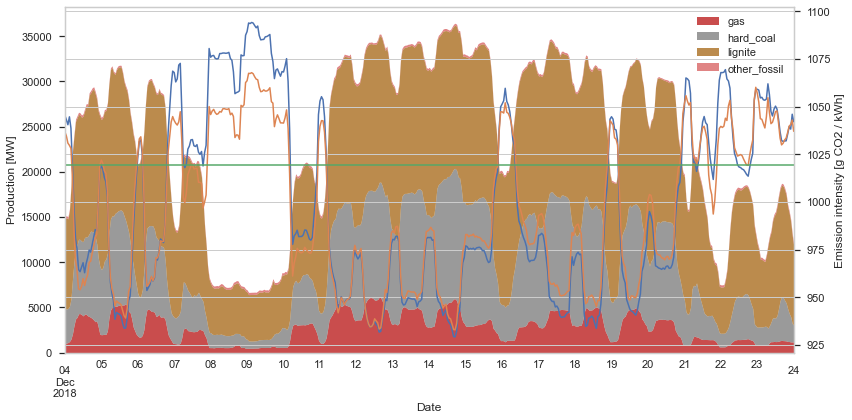

In [31]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

#Carbon_intensitiy_per_country_unit_EF
#Carbon_intensitiy_per_country_tech_EF
#Carbon_intensitiy_per_country_country_EF

plot_production_profile(generation_per_unit, CO2_emission_per_unit_EF, CO2_emission_per_tech_EF, CO2_emission_per_country_EF, generation_unit_info, 'DE', start, end)


# ENTSO-E generation per technology CO2 Signal

In this section we using the country specific EF for generating an CO2 emission signal for all EU countries. The production data are based on the production per type data from ENTSO-E

In [32]:
# take a look at the generation data
entsoe_gen_type.head(5)

region                         AT                                     \
variable                  biomass   gas geothermal hard_coal   hydro   
utc_timestamp                                                          
2018-01-01 00:00:00+00:00   316.0  71.0        0.0     150.0   751.0   
2018-01-01 01:00:00+00:00   316.0  70.0        0.0     149.0  1538.0   
2018-01-01 02:00:00+00:00   316.0  69.0        0.0     149.0    62.0   
2018-01-01 03:00:00+00:00   316.0  72.0        0.0     149.0  1548.0   
2018-01-01 04:00:00+00:00   316.0  75.0        0.0     149.0    40.0   

region                                                                BE  ...  \
variable                  other_fossil solar  waste wind_onshore biomass  ...   
utc_timestamp                                                             ...   
2018-01-01 00:00:00+00:00         22.0   0.0  100.0        832.0  232.46  ...   
2018-01-01 01:00:00+00:00         22.0   0.0  100.0        926.0  153.58  ...   
2018-01-01 02:00:00+00:00         22.0   0.0  100.0        692.0  133.70  ...   
2018-01-01 03:00:00+00:00         22.0   0.0  100.0        453.0  131.38  ...   
2018-01-01 04:00:00+00:00         22.0   0.0  100.0        321.0  131.26  ...   

region                         SK                                             \
variable                  biomass    gas hard_coal     hydro lignite nuclear   
utc_timestamp                                                                  
2018-01-01 00:00:00+00:00    28.2  175.6      48.1  455.9300   179.5  1819.3   
2018-01-01 01:00:00+00:00    28.1  172.9      48.0  499.8967   177.9  1816.7   
2018-01-01 02:00:00+00:00    28.1  162.1      46.7  543.8633   174.7  1808.7   
2018-01-01 03:00:00+00:00    29.7  140.3      45.3  587.8300   168.5  1803.6   
2018-01-01 04:00:00+00:00    29.5  143.5      46.4  552.4800   170.6  1809.1   

region                                                              
variable                    oil other_fossil other_renewable solar  
utc_timestamp                                                       
2018-01-01 00:00:00+00:00  42.3        436.5            41.4   0.0  
2018-01-01 01:00:00+00:00  42.0        433.8            41.0   0.0  
2018-01-01 02:00:00+00:00  43.8        425.7            40.8   0.0  
2018-01-01 03:00:00+00:00  40.2        415.4            39.4   0.0  
2018-01-01 04:00:00+00:00  40.2        421.3            40.4   0.0  

[5 rows x 424 columns]

In [33]:
# take a look at the EF data
EF

EF Verified_EF
MapCode ProductionTypeName                      
AT      gas                 0.360910        True
        hard_coal           1.069627        True
BE      gas                 0.389955        True
CZ      hard_coal           1.010505        True
        lignite             0.932336        True
DE      gas                 0.434490        True
        hard_coal           0.909259        True
        lignite             1.135463        True
        other_fossil        1.402450        True
DK      gas                 0.456925       False
        hard_coal           0.959711        True
ES      gas                 0.386506        True
        hard_coal           0.975777        True
FI      gas                 0.426210        True
        hard_coal           0.960352        True
        other_fossil        0.861855        True
FR      gas                 0.396383        True
        hard_coal           0.834945        True
GB      gas                 0.478437        True
        hard_coal           1.103223        True
GR      gas                 0.373103        True
        lignite             1.433019        True
HU      gas                 0.386797        True
        lignite             1.362365        True
IE      gas                 0.347416        True
        hard_coal           1.032204        True
IT      gas                 0.398540        True
        hard_coal           0.997673        True
        other_fossil        0.516962       False
LT      gas                 0.571921       False
NL      gas                 0.373476        True
        hard_coal           0.984564        True
PL      gas                 0.505579       False
        hard_coal           0.945580        True
        lignite             1.162487        True
PT      gas                 0.430328        True
        hard_coal           0.546439       False
RO      gas                 0.575246       False
        hard_coal           1.229018        True
        lignite             1.014415        True
SE      gas                 0.492360         NaN
SK      hard_coal           0.907594        True
        lignite             1.351470        True

In [34]:
# If no country-specific EFs are available, we use the following EFs. Source:
EF_stand = {'biomass':0,
            'gas':0.49,
            'geothermal':0,
            'hard_coal':0.82,
            'hydro':0,
            'lignite':1.1,
            'nuclear':0,
            'oil':0.51,
            'other_fossil':0.51,
            'other_renewable':0,
            'solar':0,
            'waste':0.5,
            'wind_offshore':0,
            'wind_onshore':0}

In [35]:
# Create a dataframe with the EF for each country and technology. If no specific EF is available, we use the default EF.
EF_multi = {}

for i in entsoe_gen_type.columns:
    if i in EF:
        EF_multi[i] = EF[i]
    else:
        EF_multi[i] = EF_stand[i[1]]

In [36]:
# calculate emissions based on EF and generation per type
CO2_emission_entsoe_gen_type = entsoe_gen_type * EF_multi

In [37]:
# From the previously calculated emissions, an emission signal (g CO2 / kWh) can now be calculated for each country.
# Since emissions and generation are available per technology, they must first be grouped and summed. 
CO2_emission = (CO2_emission_entsoe_gen_type * 1000000).groupby(level=0, axis=1).sum()
Generation = (entsoe_gen_type * 1000).groupby(level=0, axis=1).sum()

Carbon_intensitiy_entsoe_gen_type = CO2_emission.div(Generation)

## Plots

This section is to see some plots for the generated data

### CO2 Signal Example

In [38]:
def plot_production_profile_2(generation, Carbon_intensitiy, countries, start, end):
    
    # load and filter data
    generation = generation[countries]
    Carbon_intensitiy = Carbon_intensitiy[countries]
    
    
    #plotting
    import seaborn as sns

    sns.set(style="whitegrid")

    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'waste': '#68896b',
              'wind_onshore': '#235ebc',
              'wind_offshore': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a',
              'other_renewable':'#08ad97'}

    generation = generation.loc[start:end]
    Carbon_intensitiy = Carbon_intensitiy.loc[start:end]



    #order of col
    #cols = ['lignite', 'hard_coal',  'gas']#, 'other_fossil']

    #p_by_carrier = p_by_carrier[cols]



    fig,ax = plt.subplots(1,1)

    fig.set_size_inches(12,6)

    generation.plot(kind="area",
                        ax=ax,
                        linewidth=0,
                        color=[colors[col] for col in generation.columns],
                        alpha=0.7)



    ax.set_ylabel("Production [MW]")
    ax.set_xlabel("Date")
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.5))

    #ax3 = ax.twinx()
    Carbon_intensitiy.plot(ax=ax, secondary_y=True, legend=False)

    ax.right_ax.set_ylabel("Emission intensity [g CO2 / kWh]")

    #ax.set_xlim(0,snapLength-1)
    #ax.set_ylim(0,150000)
    #ax.right_ax.set_ylim(0,0.1)
    plt.tight_layout()
    
    return

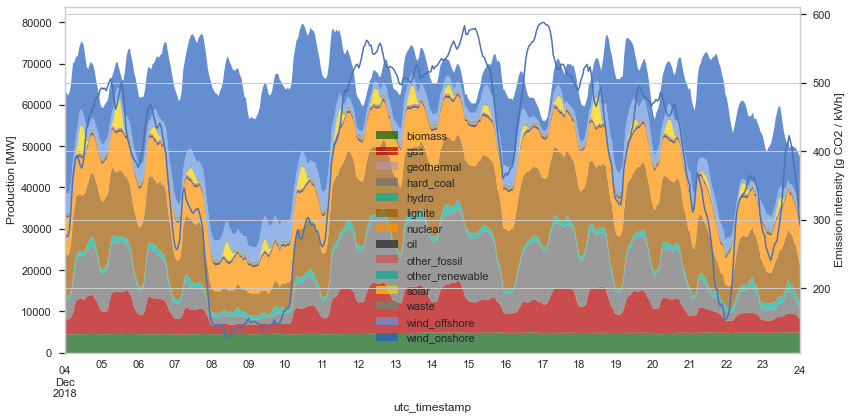

In [39]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, 'DE', start, end)

### CO2 Duration Curves

In [40]:
countries = Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns

#### One Figure

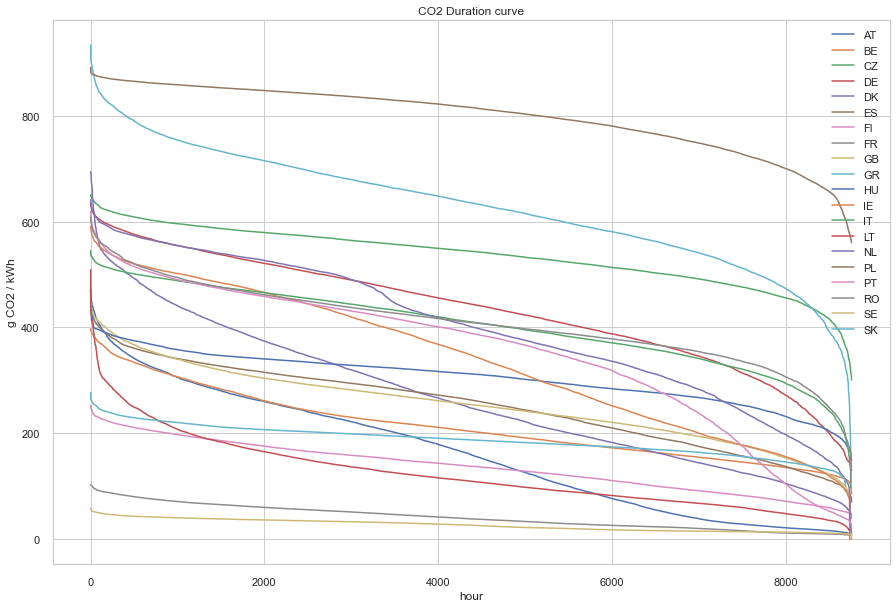

In [41]:
fig, ax = plt.subplots()

for i in countries:    
    ax.plot(range(0,8760), Carbon_intensitiy_entsoe_gen_type[i].sort_values(ascending=False), label = 'CO2 Duration curve')


    
ax.legend(countries ,loc='upper right')
ax.set_xlabel('hour')
ax.set_ylabel('g CO2 / kWh')
plt.title('CO2 Duration curve')
plt.show()

#### Multi sub Figures

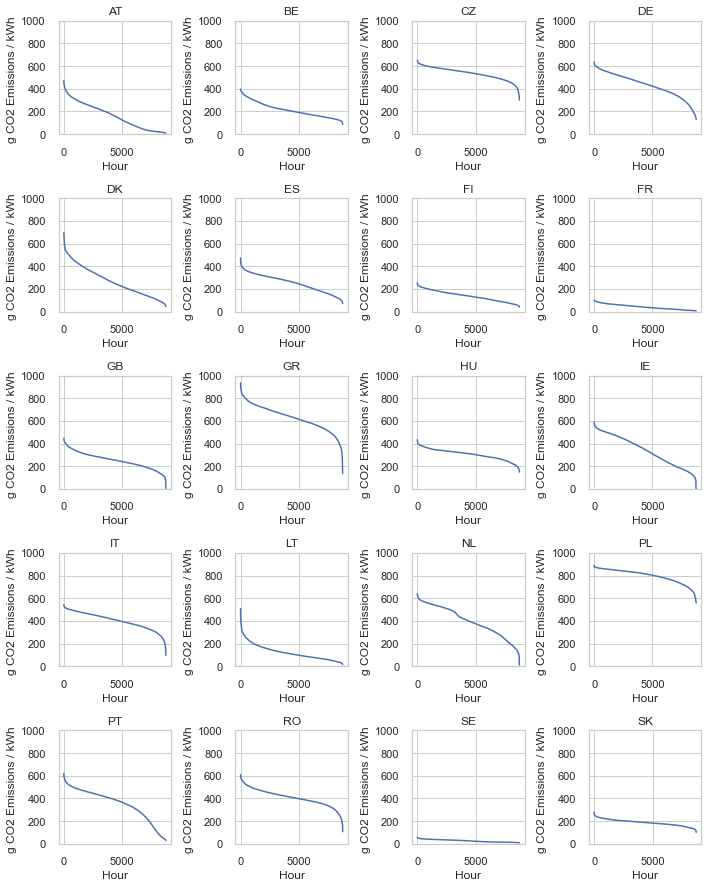

In [42]:
n_graphs = len(Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns)
n_cols = 4
    
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

#fig.delaxes(axes[3][4])

size = 2.5

fig.set_size_inches(size*n_cols,size*n_rows)
    
    
for i, country in enumerate(Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns):
    i_row = i // n_cols
    i_col = i % n_cols
        
    ax = axes[i_row,i_col]
    
    #ax.set(aspect='equal')
    
    ax.plot(range(0,8760), Carbon_intensitiy_entsoe_gen_type[country].sort_values(ascending=False), label = 'CO2 Duration curve')
    
        #max_lim = (max(entso_DE.loc[:,tech].max(),generation_DE.loc[:,tech].max())//1000)*1000+1000
        #if max_lim < 0:
        #    max_lim = 0
        
        #min_lim = (min(entso_DE.loc[:,tech].min(),generation_DE.loc[:,tech].min())//1000)*1000-1000
        #if min_lim < 0:
        #    min_lim = 0
    
    ax.set_title(country)
    #ax.set_xlim(min_lim,max_lim)
    ax.set_ylim(0,1000)
        
    ax.set_xlabel("Hour")
    ax.set_ylabel("g CO2 Emissions / kWh ")
    
    fig.tight_layout()
    
#ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(2.8, 0.5))

### Carbon Intensity Heat Map 

<AxesSubplot:xlabel='utc_timestamp', ylabel='region'>

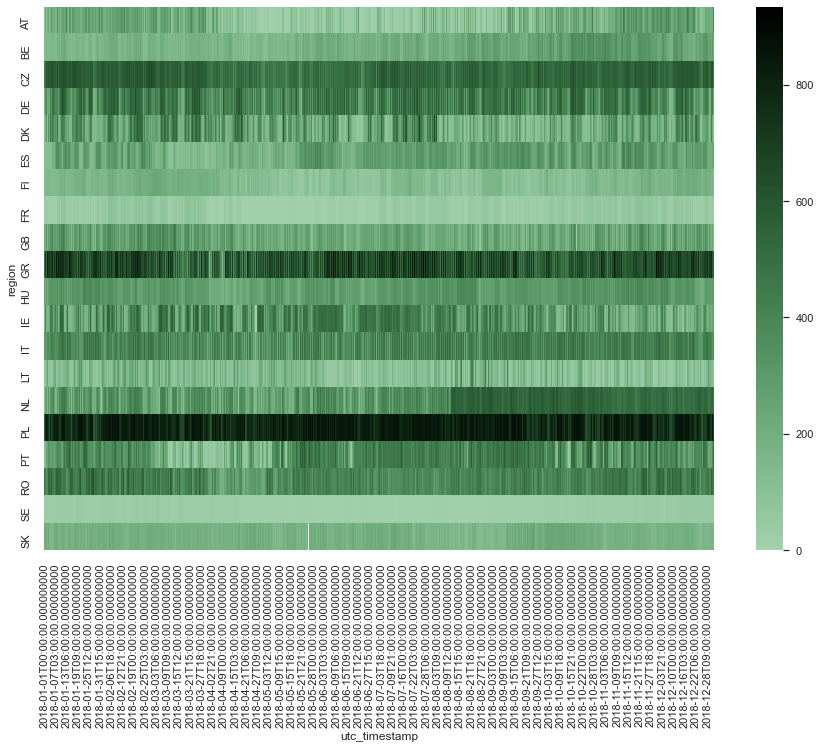

In [43]:
# all countries
sns.heatmap(Carbon_intensitiy_entsoe_gen_type[countries].transpose(), cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.75, reverse=False, as_cmap=True))

In [44]:
# use Germany as an aingle country example
df = Carbon_intensitiy_entsoe_gen_type['DE'].to_frame().copy()

In [45]:
df.head()

,DE
utc_timestamp,
2018-01-01 00:00:00+00:00,185.922842
2018-01-01 01:00:00+00:00,183.781766
2018-01-01 02:00:00+00:00,179.350694
2018-01-01 03:00:00+00:00,179.904527
2018-01-01 04:00:00+00:00,178.047945


In [46]:
# def names for the heat map
df['month'] = df.index.month_name()
df['day'] = df.index.day_name()
df['hour']=df.index.hour
df['date']=df.index.date
df.head()

,DE,month,day,hour,date
utc_timestamp,,,,,
2018-01-01 00:00:00+00:00,185.922842,January,Monday,0,2018-01-01
2018-01-01 01:00:00+00:00,183.781766,January,Monday,1,2018-01-01
2018-01-01 02:00:00+00:00,179.350694,January,Monday,2,2018-01-01
2018-01-01 03:00:00+00:00,179.904527,January,Monday,3,2018-01-01
2018-01-01 04:00:00+00:00,178.047945,January,Monday,4,2018-01-01


In [47]:
# group the values
df1 = df.groupby(['month', 'hour'],sort=False).agg(['mean'])
df1.columns=df1.columns.droplevel(0)
df1.reset_index(inplace=True)
df1.head()

,month,hour,mean
0,January,0,365.870769
1,January,1,362.946139
2,January,2,360.578711
3,January,3,363.631479
4,January,4,376.122978


In [48]:
# pandas pivot with multiple variables
heatmap_data = pd.pivot_table(df1, values='mean', index=['month'], columns='hour')
# print to see few rows and columns
print(heatmap_data.iloc[0:3, 0:3])

hour               0           1           2
month                                       
April     426.152286  422.538772  424.625968
August    482.817634  482.951202  486.943439
December  345.400818  344.146149  344.198854


In [49]:
months=df1.month.unique().tolist()
print(months)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [50]:
heatmap_data=heatmap_data.loc[months]

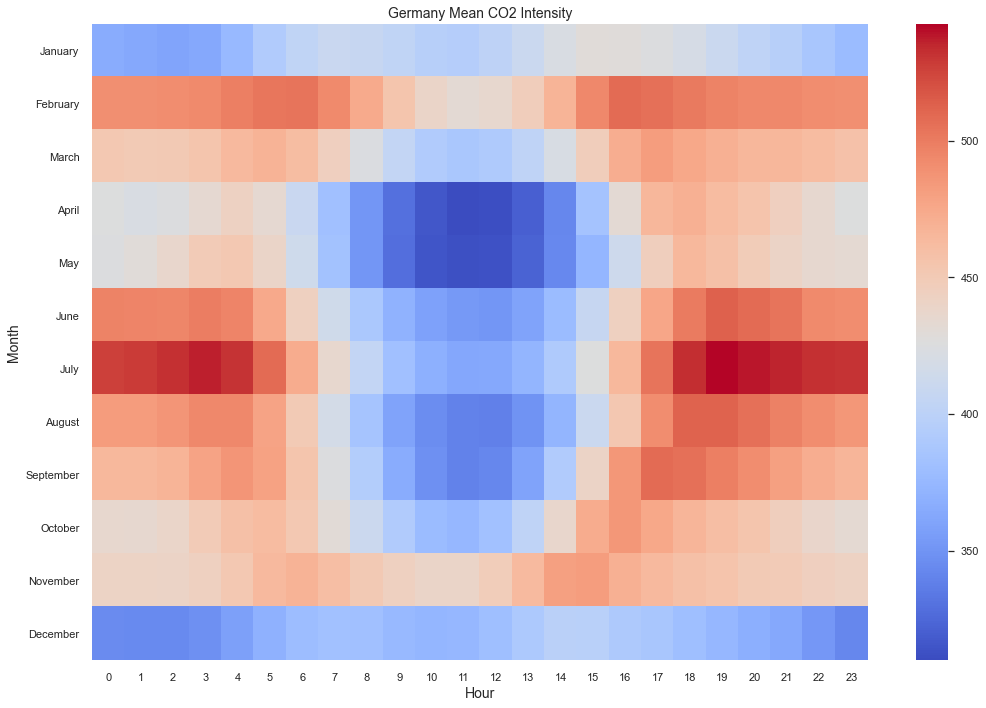

In [51]:
sns.heatmap(heatmap_data,cmap="coolwarm")
plt.xlabel("Hour", size=14)
plt.ylabel("Month", size=14)
plt.title("Germany Mean CO2 Intensity", size=14)
plt.tight_layout()

# Export final CO2 signals

In [52]:
Carbon_intensitiy_entsoe_gen_type.to_csv(processed_directory_path + '/CI_bottom_up_methode.csv')
Carbon_intensitiy_entsoe_gen_type.to_csv(output_directory_path + '/CI_bottom_up_methode.csv')